In [1]:
# Importing the Standard Libraries here
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Importing the datasets

data= pd.read_csv('Data/BigMartSalesPrediction/Train_BigMartSalesPrediction.csv')

## Exploring the datasets

In [4]:
print(data.shape)

(8523, 12)


In [5]:
data.describe()
# we see that these are the numeric columns, we will verify this in a moment and make changes if needed.

(8523, 12)


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [6]:
# we will see if the numerical columns have some relationship with eachother
# before that we will check if pandas infered all the columns correctly, make changes if not.

data.info()
# we see that all of them to be correct, except year column. we will check the values first.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [7]:
# before everything else we will check if there are any missing data in the dataset

data.isna().sum()
# we see missing data in Two variables, the third ids due to appending the test set.

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [8]:
data['Item_Weight'].interpolate(inplace= True)

# Let's check the values in there. 

print(data['Item_Weight'].isna().sum())
data['Item_Weight'].sample(10)

# we see that the value has been filled

0


631     17.100000
5880    18.816667
60      10.000000
1957    13.100000
6688     7.615000
7455    10.195000
877      6.590000
3633     4.905000
2908    18.200000
8130    11.500000
Name: Item_Weight, dtype: float64

In [9]:
# We need to impute the values on this variable

print(data['Outlet_Size'].isna().sum())

data['Outlet_Size'].fillna(data['Outlet_Size'].mode()[0], inplace= True)

print(data['Outlet_Size'].isna().sum())

# we imputed the missing values, now we will proceed

2410
0


In [10]:
print(f'Number of uniqure values in "Estd.Year" is: {data.Outlet_Establishment_Year.nunique()}')
print(data.Outlet_Establishment_Year.value_counts(dropna= False))

# we will convert this in to an object as there aren't many values

Number of uniqure values in "Estd.Year" is: 9
1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64


In [11]:
data['Outlet_Establishment_Year']= data.Outlet_Establishment_Year.astype('object')

In [12]:
print(data.Outlet_Establishment_Year.dtype)

# we see that data type is now an object

object


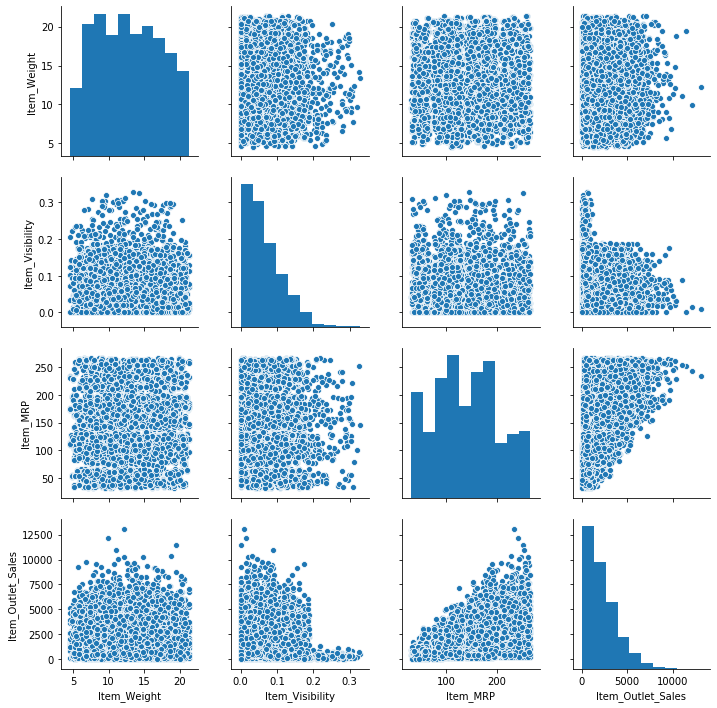

In [13]:
# we will now see a pairpolot of the numerical columns

num_cols= [*data.select_dtypes(['int64', 'float64']).columns]

sns.pairplot(data[num_cols])

# we don't see a lot of serious relationships betweem the variables and the target variables,
# we will plot a more meaningful plot using seaborn

In [14]:
num_cols.remove('Item_Outlet_Sales')
num_cols

['Item_Weight', 'Item_Visibility', 'Item_MRP']

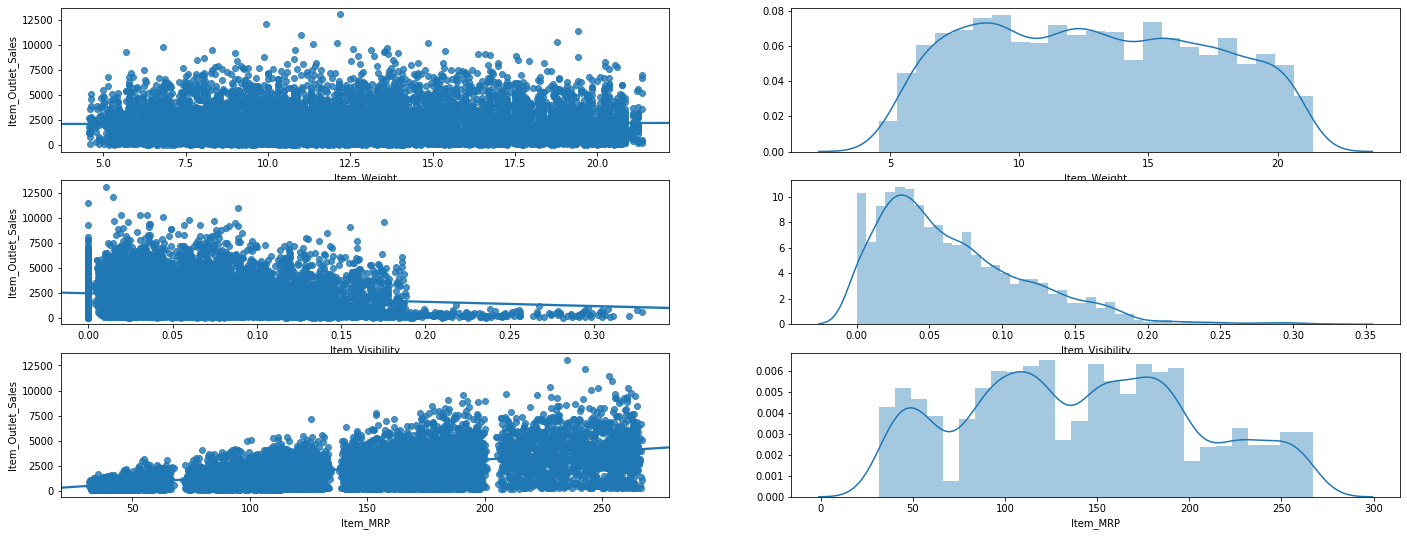

In [15]:
plt.figure(figsize= (24, 9))

count= 1

for col in num_cols:
    
    plt.subplot(3, 2, count)
    
    sns.regplot(x= col, y= 'Item_Outlet_Sales', data= data)
    
    plt.xlabel(col)
    
    count+=1
    
    plt.subplot(3, 2, count)
    
    sns.distplot(data.loc[data[col].notnull(), col])
    
    count+= 1
    
    # We can't see no clear relationship in the data

In [16]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [17]:
# We'll check the values of categorical columns ('objects')

obj_cols= [*data.select_dtypes('object').columns]

obj_cols

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [18]:
for col in obj_cols:
    
    if data[col].nunique() > 10:
        print(f'Number of unique values in {col} is {data[col].nunique()} so not printing values.')
        print(" ")
    else:
        
        print(f'Values in {col} are: \n {data[col].value_counts()}')
        print(" ")
        
# we see that there are duplicate values in the Item_Fat_Content. We'll work on it

Number of unique values in Item_Identifier is 1559 so not printing values.
 
Values in Item_Fat_Content are: 
 Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
 
Number of unique values in Item_Type is 16 so not printing values.
 
Values in Outlet_Identifier are: 
 OUT027    935
OUT013    932
OUT035    930
OUT046    930
OUT049    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64
 
Values in Outlet_Establishment_Year are: 
 1985    1463
1987     932
2004     930
1999     930
1997     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64
 
Values in Outlet_Size are: 
 Medium    5203
Small     2388
High       932
Name: Outlet_Size, dtype: int64
 
Values in Outlet_Location_Type are: 
 Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64
 
Values in Outlet_Type are: 
 Supermarket Typ

In [19]:
data['Item_Fat_Content'].value_counts(dropna= False)

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [20]:
data['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'}, inplace= True)

# We will check the values again
data['Item_Fat_Content'].value_counts(dropna= False)
# seems we have replace correctly

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [21]:
# We also saw that there are 1559 unique values in Item_Identifier column and the total number of observations are close to 8k
# let's check this out

print(data['Item_Identifier'].sample(10)) # Let's try extracting the first three letters from the variable and check if there's a pattern

print(data['Item_Identifier'].str[:3].value_counts(dropna= False)) # looks like there are 71 values

print(data['Item_Identifier'].str[:2].value_counts(dropna= False)) # looks like there are only 3 values if we extract 2 letters

data['Item_Identifier']= data['Item_Identifier'].str[:2]

7376    FDH26
5527    FDU34
7710    NCR18
3100    FDX21
784     FDO45
196     FDB41
2852    FDB33
3885    FDS28
358     FDH40
67      FDZ03
Name: Item_Identifier, dtype: object
FDX    295
FDT    281
FDS    279
FDR    275
FDW    271
FDY    271
FDV    270
FDZ    264
FDU    263
FDA    245
FDB    245
FDQ    241
FDO    233
FDP    228
FDH    223
FDC    219
FDD    218
FDL    213
FDG    213
FDK    207
FDI    206
FDN    199
FDE    199
FDF    197
FDJ    194
FDM    176
NCO     93
NCN     88
NCM     82
NCP     81
      ... 
DRD     63
NCR     63
NCJ     62
NCE     59
NCX     59
NCS     59
NCB     58
NCY     56
NCZ     56
NCH     54
NCF     52
NCA     52
NCV     52
NCU     50
DRL     50
NCD     49
NCC     48
NCT     47
NCW     45
NCG     43
DRM     43
DRC     37
DRN     34
DRB     25
DRA     21
DRO     14
DRP     12
DRZ     11
DRQ      7
DRY      6
Name: Item_Identifier, Length: 71, dtype: int64
FD    6125
NC    1599
DR     799
Name: Item_Identifier, dtype: int64


In [22]:
# We see that there is a value called NC, non-consumable, we will have to change fat content

data['Item_Fat_Content']= np.where(data['Item_Identifier']== 'NC', 'Non-durable', data['Item_Fat_Content'])

In [23]:
data.sample(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
1150,FD,11.500000,Regular,0.037539,Snack Foods,106.9254,OUT013,1987,High,Tier 3,Supermarket Type1,3038.7112
4741,FD,14.300000,Regular,0.034606,Baking Goods,95.9726,OUT017,2007,Medium,Tier 2,Supermarket Type1,2153.1972
4630,FD,8.905000,Low Fat,0.143712,Frozen Foods,60.2878,OUT018,2009,Medium,Tier 3,Supermarket Type2,1151.1682
7538,DR,15.700000,Low Fat,0.037384,Soft Drinks,179.7634,OUT018,2009,Medium,Tier 3,Supermarket Type2,1817.6340
3507,FD,16.925000,Regular,0.052041,Dairy,143.1786,OUT019,1985,Small,Tier 1,Grocery Store,288.9572
6995,DR,9.500000,Low Fat,0.085020,Hard Drinks,188.7872,OUT013,1987,High,Tier 3,Supermarket Type1,1701.7848
300,FD,10.000000,Regular,0.027477,Canned,87.9856,OUT027,1985,Medium,Tier 3,Supermarket Type3,3251.7672
7438,FD,17.916667,Regular,0.000000,Snack Foods,262.8910,OUT019,1985,Small,Tier 1,Grocery Store,788.9730
2664,FD,6.800000,Low Fat,0.037490,Baking Goods,48.6034,OUT035,2004,Small,Tier 2,Supermarket Type1,291.6204
1934,NC,8.420000,Non-durable,0.070556,Household,216.0192,OUT035,2004,Small,Tier 2,Supermarket Type1,2372.9112


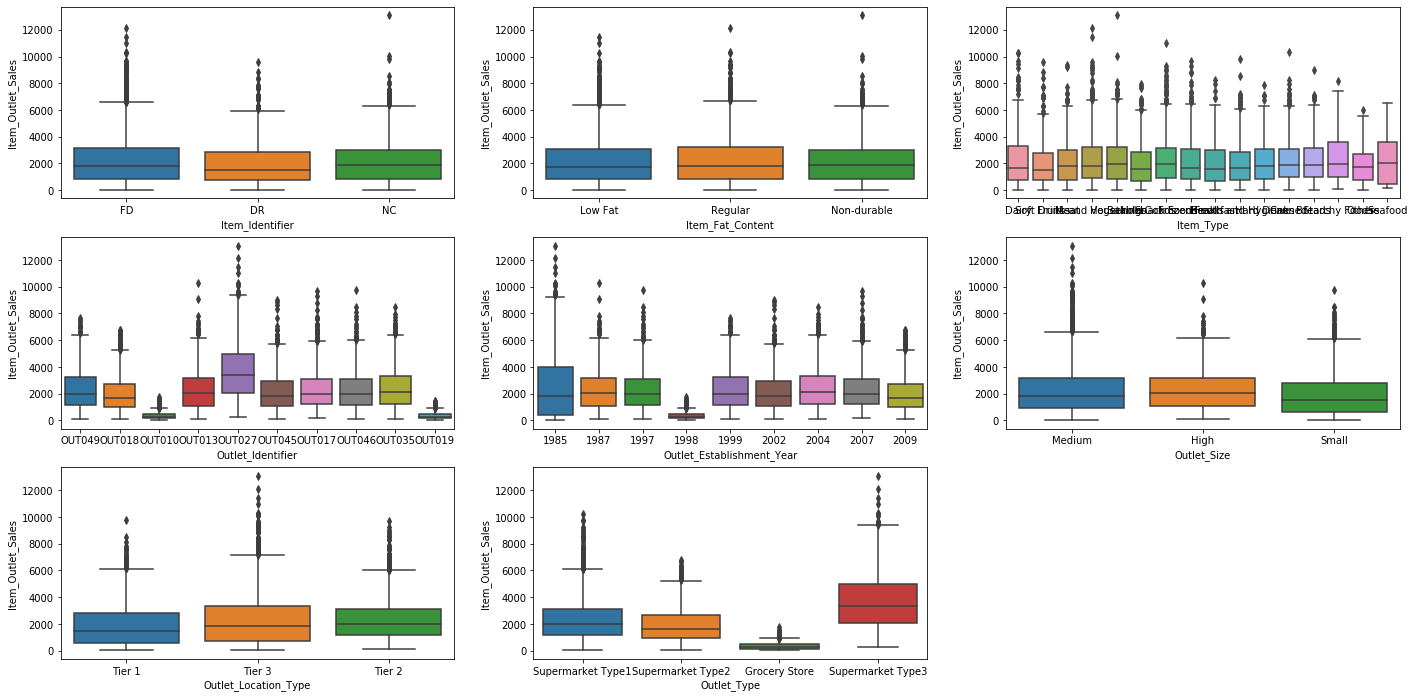

In [24]:
plt.figure(figsize= (24, 12))

for idx, col in enumerate(obj_cols):
    
    plt.subplot(3, 3, idx+1)
    
    sns.boxplot(col, 'Item_Outlet_Sales', data= data)

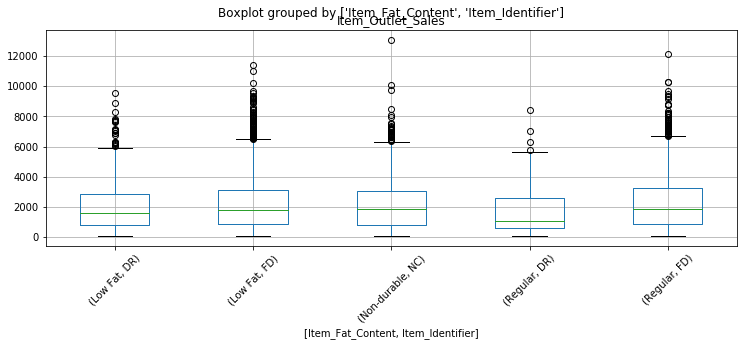

In [25]:
data.boxplot(column= 'Item_Outlet_Sales', by= ['Item_Fat_Content', 'Item_Identifier'], figsize= (12, 4), rot= 45)

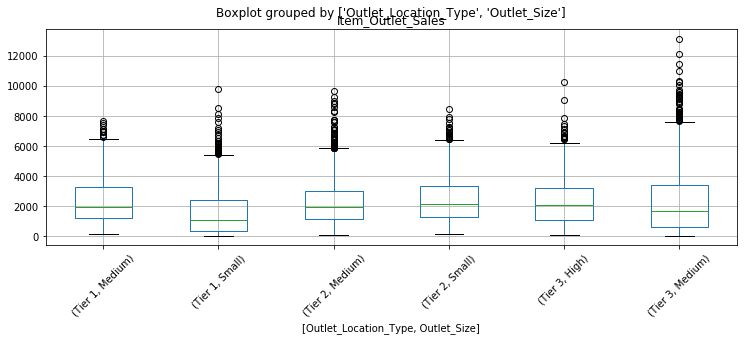

In [26]:
data.boxplot(column= 'Item_Outlet_Sales', by= ['Outlet_Location_Type', 'Outlet_Size'], figsize= (12, 4), rot= 45)

In [27]:
# we'll create a dummy dataframe from the preprocessed dataFrame


df= pd.get_dummies(data, drop_first= True)

In [28]:
for col in num_cols:
    
    print(f'Minimum value in {col} is: {data[col].min()}')
    print(" ")
    print(f'Minimum value in {col} is: {data[col].max()}')
    print(" ")
    
    # seems like there 

Minimum value in Item_Weight is: 4.555
 
Minimum value in Item_Weight is: 21.35
 
Minimum value in Item_Visibility is: 0.0
 
Minimum value in Item_Visibility is: 0.328390948
 
Minimum value in Item_MRP is: 31.29
 
Minimum value in Item_MRP is: 266.8884
 


In [29]:
df['Non-Visible']= np.where(df['Item_Visibility']==0, 1, 0)

df['Non-Visible'].value_counts(dropna= False)

0    7997
1     526
Name: Non-Visible, dtype: int64

In [30]:
df.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Item_Identifier_FD,Item_Identifier_NC,Item_Fat_Content_Non-durable,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Establishment_Year_2007,Outlet_Establishment_Year_2009,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Non-Visible
0,9.30,0.016047,249.8092,3735.1380,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,5.92,0.019278,48.2692,443.4228,0,0,0,1,0,0,...,0,1,1,0,0,1,0,1,0,0
2,17.50,0.016760,141.6180,2097.2700,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,19.20,0.000000,182.0950,732.3800,1,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1
4,8.93,0.000000,53.8614,994.7052,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,0,1


In [31]:
df.isna().sum()

Item_Weight                        0
Item_Visibility                    0
Item_MRP                           0
Item_Outlet_Sales                  0
Item_Identifier_FD                 0
Item_Identifier_NC                 0
Item_Fat_Content_Non-durable       0
Item_Fat_Content_Regular           0
Item_Type_Breads                   0
Item_Type_Breakfast                0
Item_Type_Canned                   0
Item_Type_Dairy                    0
Item_Type_Frozen Foods             0
Item_Type_Fruits and Vegetables    0
Item_Type_Hard Drinks              0
Item_Type_Health and Hygiene       0
Item_Type_Household                0
Item_Type_Meat                     0
Item_Type_Others                   0
Item_Type_Seafood                  0
Item_Type_Snack Foods              0
Item_Type_Soft Drinks              0
Item_Type_Starchy Foods            0
Outlet_Identifier_OUT013           0
Outlet_Identifier_OUT017           0
Outlet_Identifier_OUT018           0
Outlet_Identifier_OUT019           0
O

In [32]:
X, y= df.drop('Item_Outlet_Sales', axis= 1), df.Item_Outlet_Sales

In [33]:
X.shape, y.shape

((8523, 47), (8523,))

In [34]:
y.head()

0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

In [35]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state= 123)

In [36]:
lr = LinearRegression()

lr.fit(X_train, y_train)

lr_pred= lr.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, lr_pred)))

1113.939184607956


In [37]:
rf= RandomForestRegressor(max_depth= 5)

rf.fit(X_train, y_train)

rf_pred= rf.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, rf_pred)))

# We get a better score from a RandomForest Model

1079.1475736483992


/Users/pratikajitb/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [38]:
gbm= GradientBoostingRegressor(max_depth= 2)

gbm.fit(X_train, y_train)

gbm_pred= gbm.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, gbm_pred)))

# we get a slightly better score.

1064.0813624375799


In [39]:
from sklearn.metrics import make_scorer

In [40]:
# creating a custom scoring function for cross validation

def RMSE(y_true, y_pred):
    
    RMSE = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    return RMSE

rmse= make_scorer(RMSE, greater_is_better= False)

In [41]:
score= cross_val_score(estimator= gbm, X= X_train, y= y_train, scoring= rmse, cv= 5,\
                n_jobs= -1, verbose= 1)

score.mean(), score.std()
# we get negative score as the scorer function returns negative score in cross validation

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.8s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


(-1086.205262047582, 34.055403896416045)

In [42]:
et= ExtraTreesRegressor()

et.fit(X_train, y_train)

et_pred= et.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, et_pred)))

# we get a slightly better score.

/Users/pratikajitb/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1221.7910560793339


In [43]:
iso_forest= IsolationForest(contamination= 'auto', behaviour= 'New')

outliers= iso_forest.fit_predict(X, y)

pd.Series(outliers).value_counts(dropna= False)

# -1 indicate that the values are outliers

 1    8312
-1     211
dtype: int64

In [44]:
# we will remove the outliers from the original predictor(X) and traget(y) variables

out_bool= outliers == 1

X_new, y_new= X[out_bool], y[out_bool]

In [45]:
X_new.shape, y_new.shape

# we'll now create new train and test values

((8312, 47), (8312,))

In [46]:
X_train, X_test, y_train, y_test= train_test_split(X_new, y_new, random_state= 123, test_size= 0.2)

# splitting data 80/20

In [47]:
lr= LinearRegression()

lr.fit(X_train, y_train)

lr_pred= lr.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, lr_pred)))

1159.3449333633262


In [48]:
rf= RandomForestRegressor(max_depth= 5)

rf.fit(X_train, y_train)

rf_pred= rf.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, rf_pred)))

# the score improves a little.

1106.3222261632375


/Users/pratikajitb/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [49]:
gbm= GradientBoostingRegressor(max_depth= 2)

gbm.fit(X_train, y_train)

gbm_pred= gbm.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, gbm_pred)))

# We see a slight improvement in the socre after removing the outliers

1101.950004187861


In [50]:
# we can perform a GridSearch to see if we can improve the score further

gbm_params= {'max_depth': np.arange(1, 10, 2), "max_features": [.7, .8, .9],
             'max_leaf_nodes': np.arange(2, 10, 2), "min_samples_leaf": np.arange(1, 10, 2),
             'min_samples_split': np.arange(2, 10, 2)}

gbm_grid= GridSearchCV(gbm, gbm_params, scoring= rmse, n_jobs= -1, cv= 3, verbose= 1)

gbm_grid.fit(X_train, y_train)

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  8.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=2,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter...
                             

In [51]:
gbm_grid_pred= gbm_grid.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, gbm_grid_pred)))

# We see almost the same score

1099.34614041462
